In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from tqdm import tqdm
from censai import PhysicalModelv2
from censai.data.lenses_tng_v3 import decode_all, decode_train, decode_physical_model_info
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.definitions import log_10
import tensorflow_probability as tfp
from censai import PhysicalModelv2
from censai import PhysicalModelv2, RIMKappaUnetv2
from censai.models import UnetModelv2, RayTracer

In [2]:
datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_rau_200k_control_denoised"


files = glob.glob(os.path.join(datapath, "*.tfrecords"))
# files = [os.path.join(datapath, "data_10.tfrecords")]
files = tf.data.Dataset.from_tensor_slices(files)

dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
print(physical_params)
# Read off global parameters from first example in dataset

dataset = dataset.map(decode_all)

{'image fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'kappa fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'source fov': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'src pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'kappa pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>}


In [3]:
phys = PhysicalModelv2(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method="fft",
)


In [5]:

kappas = []
galaxies = []
lenses = []
noise_rms = []
psf = []
i = 0
for example in tqdm(dataset):
    kappas.append(example['kappa'])
    galaxies.append(example['source'])
    lenses.append(example['lens'])
    noise_rms.append(example["noise rms"].numpy())
    psf.append(example["psf"])
    i += 1
    if i == 1000:
        break


999it [00:01, 990.11it/s] 


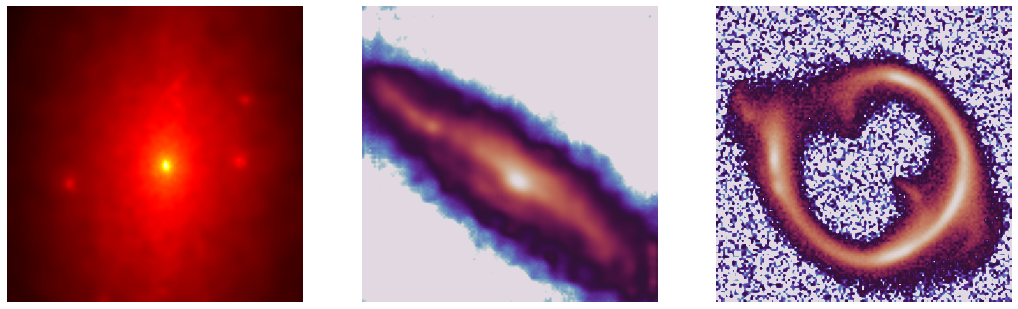

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
i = 104
axs[0].imshow(kappas[i][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[1].imshow(galaxies[i][..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4, vmax=1))
axs[2].imshow(lenses[i][..., 0], cmap= "twilight",  norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4, vmax=1))
for i in range(3):
    axs[i].axis("off")

In [7]:
kappa = tf.stack(kappas, axis=0)
source = tf.stack(galaxies, axis=0)
lens = tf.stack(lenses, axis=0)
noise_rms = tf.stack(noise_rms, axis=0)
psf = tf.stack(psf, axis=0)

In [258]:
DTYPE = tf.float32
STEPS = 10000
SAVE = 1
alpha = 1e-3 # inner step size
beta = 5e-3 # out step size
# theta = tf.zeros(shape=kappa.shape[1:])[None, ...]
fake_source = tf.ones_like(source[0])[None, ...]
n_tasks = 5
saved_theta = []
saved_cost = []


for step in tqdm(range(STEPS)):
    indexes = np.random.choice(range(1000), size=n_tasks, replace=False)
    with tf.GradientTape() as outer_tape:
        outer_tape.watch(theta)
        total_cost = 0
        for task in indexes:
            y_true = lens[task][None, ...]
            source_true  = source[task][None, ...]
            kappa_true = kappa[task][None, ...]
            _psf = psf[task][None, ...]
            noise = noise_rms[task]
            with tf.GradientTape() as tape:
                tape.watch(theta)
                y_pred = phys.forward(source_true, 10**theta, _psf)
                ll = 0.5 * tf.reduce_sum(tf.square(y_pred - y_true) / noise**2)
            grad = tape.gradient(ll, theta)
            grad = tf.clip_by_norm(grad, 1.)
            theta_prime = theta - alpha * grad
            # for outer loop
#             y_pred = phys.forward(source_true, tf.exp(theta_prime), _psf)
            prior = tf.reduce_sum(tf.square(10**theta_prime - kappa_true))
            lagrange = tf.square(tf.reduce_sum(y_pred) - tf.reduce_sum(y_true))
            total_cost += prior
    outer_grad = outer_tape.gradient(total_cost, theta)  
    outer_grad = tf.clip_by_norm(outer_grad, 5.)
    theta = theta - beta * outer_grad
    
    if step % SAVE == 0:
        saved_theta.append(theta)
        saved_cost.append(total_cost)



 33%|███▎      | 3338/10000 [06:03<12:06,  9.17it/s]  


KeyboardInterrupt: 

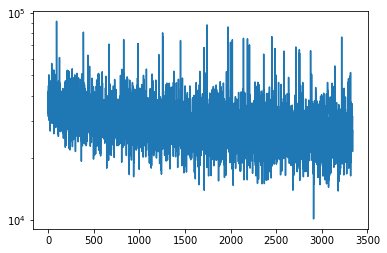

In [259]:
plt.plot(saved_cost)
plt.yscale("log")

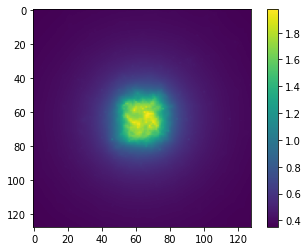

In [260]:
plt.imshow(10**theta[0, ..., 0])
plt.colorbar()

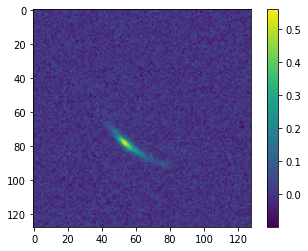

In [261]:
plt.imshow(y_true[0, ..., 0])
plt.colorbar()

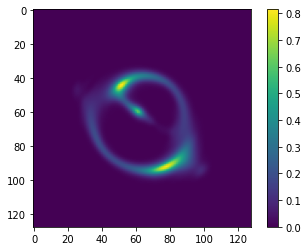

In [262]:
plt.imshow(y_pred[0, ..., 0])
plt.colorbar()

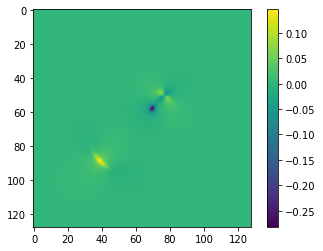

In [263]:
plt.imshow(grad[0, ..., 0])
plt.colorbar()

In [283]:
np.save("../data/meta_kappa_init.npy", theta.numpy().squeeze())

In [278]:
saved_theta = np.load("meta_kappa_init.npy")